# Homework - Classification II

***Agata Makarewicz***

*Week 8 & 9*

In [104]:
# loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

import nltk
from nltk import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, roc_auc_score, auc, plot_roc_curve, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn import metrics
from wordcloud import WordCloud,STOPWORDS

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

#### Basic information about the dataset

In [2]:
from bds_courseware import read_drive_dataset, HOMEWORK_DATASETS

name = "movies"
data = read_drive_dataset(*HOMEWORK_DATASETS[name])

In [3]:
data.shape

(50000, 2)

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


We can see that we have only two columns - `review` and `sentiment`, and none of them contains missing values. We can also spot some "words" which we will drop later on, such as HTML tags.

Let's take a closer look how one review looks like.

In [6]:
data.loc[0]['review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Let's now see how long (on average) our reviews are.

In [7]:
letters = [len(row) for row in data['review']] # letter count
splitted = [x.split() for x in data['review']] # word count
words = [len(x) for x in splitted]

In [8]:
stats = pd.concat([pd.DataFrame(letters).rename(columns={0: 'n_letters'}),
                   pd.DataFrame(words).rename(columns={0: 'n_words'})], axis=1)
stats.describe()

,n_letters,n_words
count,50000.000000,50000.000000
mean,1309.431020,231.156940
std,989.728014,171.343997
min,32.000000,4.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.250000,280.000000
max,13704.000000,2470.000000


We can see that shortest review has only 4 words, but it can be misleading - we are now performing very basic EDA and splitting words by `space`, but it is possible that someone forgot to put it after a comma. Let's check out this record.

In [9]:
data['review'][np.argmin(stats['n_words'])]

'Primary plot!Primary direction!Poor interpretation.'

There are in fact 6 words instead of four in this review. Later on we will perform tokenization which will handle such situations as missing spaces between words (splitting the words better).

But we are interested in distinction between positive and negative reviews - let's check how it looks like for each of them.

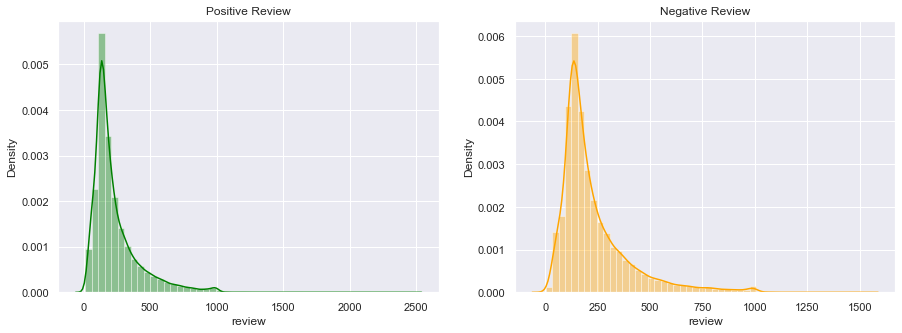

In [10]:
def plot_count(count1,count2,title_1,title_2):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count1,ax = ax1,color = 'Green')
    ax1.set_title(title_1)
    sns.distplot(count2,ax = ax2,color = 'Orange')
    ax2.set_title(title_2)
    plt.show()    

count_good = data.query('sentiment=="positive"')['review'].str.split().apply(lambda z: len(z))
count_bad = data.query('sentiment=="negative"')['review'].str.split().apply(lambda z: len(z))
plot_count(count_good,count_bad,"Positive Review","Negative Review")

In [11]:
stats2 = pd.concat([pd.DataFrame(count_good).rename(columns={'review': 'count_good'}),
                   pd.DataFrame(count_bad).rename(columns={'review': 'count_bad'})], axis=1)
stats2.describe()

,count_good,count_bad
count,25000.000000,25000.000000
mean,232.849320,229.464560
std,177.497046,164.947795
min,10.000000,4.000000
25%,125.000000,128.000000
50%,172.000000,174.000000
75%,284.000000,278.000000
max,2470.000000,1522.000000


There's practically no difference between the length of positive and negative reviews - one thig we can observe is that there are more longer reviews in case of positives (but they are rare). Further EDA will be performed after cleaning & tokenization.

#### Target analysis

negative    25000
positive    25000
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

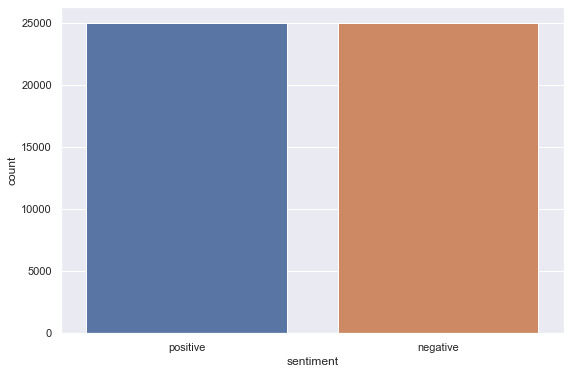

In [12]:
print(data.sentiment.value_counts())
sns.countplot(data['sentiment'])

As we can see, our target is perfectly balanced. Let's change it to binary one.

In [13]:
data['sentiment'] = data['sentiment'].replace({'positive':1,'negative':0})

### Preprocessing

#### Cleaning

In [14]:
# Remove HTML - some html tags present in the data, not important
def clean_html(data):
    html_clean = re.compile(r'<.*?>')
    data = html_clean.sub(r'',data)
    return data

In [15]:
# Remove URL - sometimes a website included, also not informative
def clean_url(data):
    url_clean = re.compile(r"https://\S+|www\.\S+")
    data = url_clean.sub(r'',data)
    return data

In [16]:
# Modify to lower - to reduce number of words and exclude duplicates differing by letter case
def clean_to_lower(text):
    return text.lower()

In [17]:
# Remove punctuations - all special chars 
def clean_special_char(data): # and numbers - also not very informative without context
    data = re.sub('\[[^]]*\]', ' ', data)
    data = re.sub('[^a-zA-Z]', ' ', data)
    return data

In [18]:
# all cleaning together
def clean_data(data):
    data = data.apply(clean_html).apply(clean_url).apply(clean_to_lower).apply(clean_special_char)
    return data

#### Tokenization

In [19]:
def tokenize_and_remove_stopwords(row):
    token = word_tokenize(row) 
    filtered_token = []
    for word in token:
        if word not in stopwords.words('english'):
            filtered_token.append(word)
    return filtered_token

#### Stemming 
*reducing words to their word stem, base or root form*

In [20]:
def stemmer(data):
    porter = PorterStemmer()
    text = [porter.stem(row) for row in data]
    text = " ".join(text)
    return text

#### Lemmatization
*grouping together the forms of a word so they can be analysed as a single item, identified by the word's lemma*

In [21]:
def lemmatizer(data):
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(row) for row in data]
    text = " ".join(text)
    return text

### Modeling

#### Train-test split

In [22]:
data_train, data_test, target_train, target_test = train_test_split(data['review'], data['sentiment'], 
                                                                    test_size=0.20, shuffle=True, random_state=123)

In [24]:
# cleaning & tokenization
data_train_clean = clean_data(data_train)
data_test_clean = clean_data(data_test)

data_train_tok = data_train_clean.apply(tokenize_and_remove_stopwords)
data_test_tok = data_test_clean.apply(tokenize_and_remove_stopwords)

In [25]:
# stemming & lemmatization
data_train_stem = data_train_tok.apply(stemmer)
data_test_stem = data_test_tok.apply(stemmer)

data_train_lemma = data_train_tok.apply(lemmatizer)
data_test_lemma = data_test_tok.apply(lemmatizer)

We created separate datasets - applying stemming and lemmatization separately - in order to compare the effectiveness of both transformations. Let's now take a closer look at our data.

In [29]:
# separating positive and negative reviews
positive_ind = target_train[target_train==1].index.to_list()
negative_ind = target_train[target_train==0].index.to_list()

In [43]:
def count_words(data):
    ngram_vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=1)
    X = ngram_vectorizer.fit_transform(data)
    vocab = list(ngram_vectorizer.get_feature_names())
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(vocab, counts)))
    print (freq_distribution.most_common(10))

In [45]:
count_words(data_train_lemma[positive_ind])

[('film', 39964), ('movie', 35570), ('one', 22495), ('like', 14568), ('time', 13020), ('good', 12040), ('story', 11369), ('character', 11233), ('see', 10375), ('great', 10334)]


In [46]:
count_words(data_train_lemma[negative_ind])

[('movie', 46818), ('film', 35085), ('one', 21783), ('like', 18358), ('time', 12257), ('even', 12254), ('bad', 11867), ('good', 11823), ('character', 11505), ('would', 11228)]


We can see that the most common words are the ones "most popular" in the world of movies. Let's filter them out to see the difference.

In [37]:
def plot_wordcloud(tokens): # filtering out words which are most common in both positive and negative
    words = ''              # based on the knowledge from above and some experiments ;)       
    for token in tokens: 
        words += " ".join(token)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=['movie','film','character','one','show','even','like','time','get','also','make','see','would','scene'],
                    min_font_size = 10).generate(words)                        
    plt.figure(figsize = (9,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()

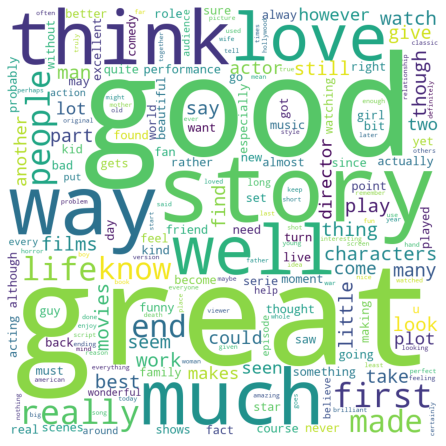

In [38]:
plot_wordcloud(data_train_tok[positive_ind]) # word cloud for positive reviews

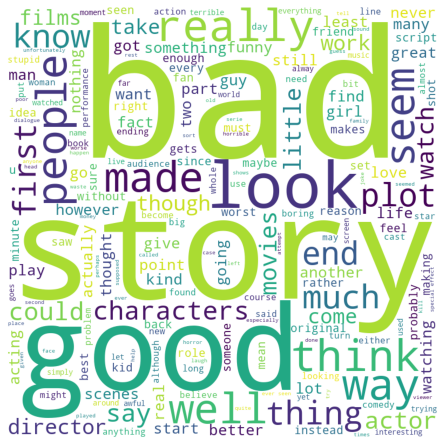

In [39]:
plot_wordcloud(data_train_tok[negative_ind]) # word cloud for negative reviews

Wordclouds tell us what we expected - after filtering out the words that are common among both groups we can see `great` and `good` dominating in positive ones and `bad` in negative, but what's interesting is that `good` is also very common among them. It it highly possible that it was included in formulas such as `not good` etc. but `not` was filtered out as a stopword.

However, following that thought, let's see if we have some meaningful, frequent "collocations" (grams) in our data.

In [55]:
# creating bi-grams frequency charts
def find_grams(data,gram):
    tokens = [t for t in data]
    ngrams = zip(*[tokens[i:] for i in range(gram)])
    final_tokens = [" ".join(z) for z in ngrams]
    return final_tokens
    
def create_dict(data,grams):
    freq_dict = defaultdict(int)
    for sentence in data:
        for tokens in find_grams(sentence,grams):
            freq_dict[tokens] += 1
    return freq_dict

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y = df["n_gram_words"].values[::-1],
        x = df["n_gram_frequency"].values[::-1],
        showlegend = False,
        orientation = 'h',
        marker = dict(color=color,),)
    return trace

def create_freq_df(freq_dict,):
    freq_df = pd.DataFrame(sorted(freq_dict.items(),key=lambda z:z[1])[::-1])
    freq_df.columns = ['n_gram_words','n_gram_frequency']
    trace = horizontal_bar_chart(freq_df[:10],'lightblue')
    return trace
    
def plot_grams(negative,positive):
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Negative reviews", "Positive reviews"])
    fig.append_trace(negative, 1, 1)
    fig.append_trace(positive, 1, 2)
    fig['layout'].update(height=400, width=800, paper_bgcolor='rgb(233,233,233)', title="Word Count")
    py.iplot(fig, filename='word-plots')

In [58]:
train_bad = data_train_tok[negative_ind]
train_good = data_train_tok[positive_ind]

print("Bi-gram analysis")
freq_bad = create_dict(train_bad,2)
neg = create_freq_df(freq_bad)
freq_good = create_dict(train_good,2)
pos = create_freq_df(freq_good)
plot_grams(neg,pos)

print("Tri-gram analysis")
freq_bad = create_dict(train_bad,3)
neg = create_freq_df(freq_bad)
freq_good=create_dict(train_good,3)
pos = create_freq_df(freq_good)
plot_grams(neg,pos)

Bi-gram analysis


Tri-gram analysis


In both - bi-gram and tri-gram analysis we can observe some characteristic phrases for both negative and positive feelings about the movie: `worst movie ever` or `one best movie` (there was probably `of` in the middle). Such grams can be really beneficial to our model, so we should definitely take them into account.

As mentioned before, we will compare model performance while using different normalization:
* stemming 
* lemmatization 

but we will also compare to different vectorization methods:
* **Bag of words**  -  *CountVectorizer*
* **TFIDF** -  *TfidfVectorizer*

Let's define some functions which we will use later on.

In [47]:
# plotting word importance for a given model
def plot_importance(coefs, colnames): 
    importance = pd.DataFrame({'Weight':coefs,'Variable': colnames})
    imp1 = importance.sort_values(by='Weight', ascending=False).head(10)
    imp2 = importance.sort_values(by='Weight', ascending=False).tail(10)
    imp = pd.concat([imp1,imp2])
    plot = sns.barplot( x='Weight',y='Variable', data=imp)
    plot.set_title('Word importance - top 10 +/-', size=14)

In [80]:
# plotting auc-roc curve to compare performance
def compare_models(model1,model2,x,y):
    fig, ax = plt.subplots(1,1,figsize=(11, 5))
    plot_roc_curve(model1,x,y, ax=ax)
    plot_roc_curve(model2,x,y, ax=ax)
    plt.legend()
    plt.show()

#### SGD Classifier (logistic regression)

In [65]:
sgd_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=1000)),
    ('model', SGDClassifier())
])

tuned_parameters = [{'model__alpha': [0.1, 1.0, 5, 10], 
                     'model__loss': ['log'], # if hinge - linear svm
                     'model__penalty': ['l2', 'elasticnet']}]

grid_search1 = GridSearchCV(sgd_pipe, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)

In [66]:
grid_search1.fit(data_train_lemma, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=  41.4s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=  33.4s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=  33.5s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=  36.4s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=  33.5s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=  33.1s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=  33.2s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=  33.1s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=  33.0s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=  32.7s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=  33.1

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=1000,
                                                        ngram_range=(1, 3))),
                                       ('model', SGDClassifier())]),
             param_grid=[{'model__alpha': [0.1, 1.0, 5, 10],
                          'model__loss': ['log'],
                          'model__penalty': ['l2', 'elasticnet']}],
             scoring='f1', verbose=2)

In [67]:
grid_search1.best_params_

{'model__alpha': 0.1, 'model__loss': 'log', 'model__penalty': 'l2'}

In [69]:
y_pred = grid_search1.predict(data_test_lemma)

In [70]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.96      0.77      4979
           1       0.92      0.47      0.63      5021

    accuracy                           0.72     10000
   macro avg       0.78      0.72      0.70     10000
weighted avg       0.78      0.72      0.70     10000



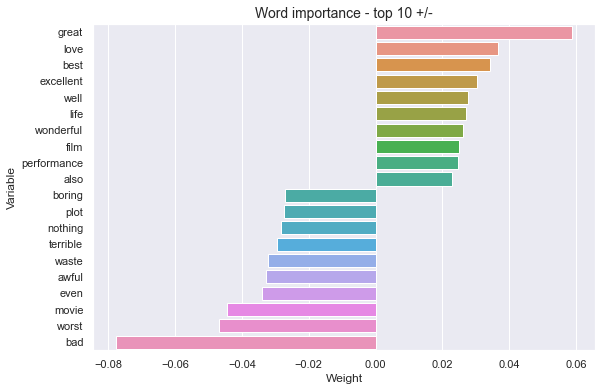

In [72]:
plot_importance(grid_search1.best_estimator_.get_params()['steps'][1][1].coef_[0],
                grid_search1.best_estimator_.get_params()['steps'][0][1].get_feature_names())

With no surprise, we can see that words such as `worst`, `bad`, `great` have the biggest impact on our prediction. As for the results - they're not really good, maybe it's because of lemmatization or vectorization - it's hard to say.

In [74]:
sgd_pipe2 = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,3), max_features=1000)),
    ('model', SGDClassifier())
])

tuned_parameters = [{'model__alpha': [0.1, 1.0, 5, 10], 
                     'model__loss': ['log'], # hinge - linear svm
                     'model__penalty': ['l2', 'elasticnet']}]

grid_search2 = GridSearchCV(sgd_pipe2, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)

In [75]:
grid_search2.fit(data_train_lemma, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=   8.3s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=   8.2s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=   7.5s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=   9.1s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=   8.1s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=   8.3s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=   8.5s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=   9.9s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=   9.0s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=   8.3s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=   8.7

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_features=1000)),
                                       ('model', SGDClassifier())]),
             param_grid=[{'model__alpha': [0.1, 1.0, 5, 10],
                          'model__loss': ['log'],
                          'model__penalty': ['l2', 'elasticnet']}],
             scoring='f1', verbose=2)

In [76]:
grid_search2.best_params_

{'model__alpha': 0.1, 'model__loss': 'log', 'model__penalty': 'l2'}

In [77]:
y_pred = grid_search2.predict(data_test_lemma)

In [78]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      4979
           1       0.81      0.84      0.82      5021

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



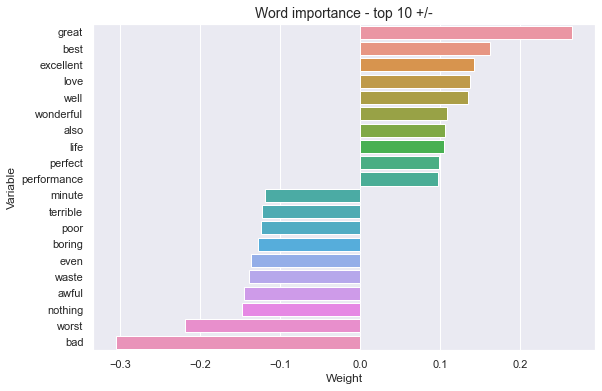

In [79]:
plot_importance(grid_search2.best_estimator_.get_params()['steps'][1][1].coef_[0],
                grid_search2.best_estimator_.get_params()['steps'][0][1].get_feature_names())

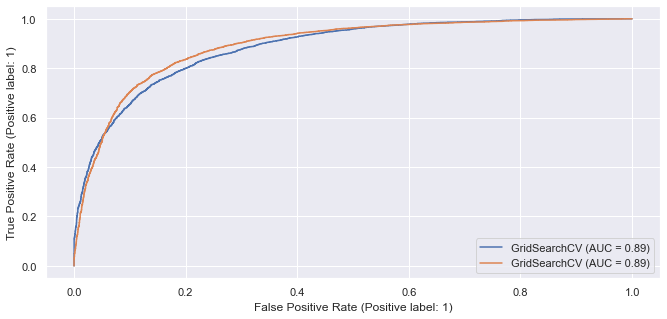

In [81]:
compare_models(grid_search1, grid_search2, data_test_lemma, target_test) # blue - tfidf, orange - countvectorizer

We can observe similar important words as before, but with smaller weights. As for the results - they are much better, we get all metrics above 80%. However in terms of roc-auc, the AUC is the same, but we can see from the curve, that the second model is better. Therefore, so far CountVectorizer + Lemmatization gave us the best results. Let's check how stemming performs.

In [86]:
sgd_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=1000)),
    ('model', SGDClassifier())
])

tuned_parameters = [{'model__alpha': [0.1, 1.0, 5, 10], 
                     'model__loss': ['log'], # if hinge - linear svm
                     'model__penalty': ['l2', 'elasticnet']}]

grid_search3 = GridSearchCV(sgd_pipe, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)

In [87]:
grid_search3.fit(data_train_stem, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time= 1.5min
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=  53.8s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=  52.6s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=  53.6s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=  52.4s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=  54.4s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=  53.1s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=  53.3s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=  55.6s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=  54.4s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=  54.2

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=1000,
                                                        ngram_range=(1, 3))),
                                       ('model', SGDClassifier())]),
             param_grid=[{'model__alpha': [0.1, 1.0, 5, 10],
                          'model__loss': ['log'],
                          'model__penalty': ['l2', 'elasticnet']}],
             scoring='f1', verbose=2)

In [88]:
grid_search3.best_params_

{'model__alpha': 0.1, 'model__loss': 'log', 'model__penalty': 'elasticnet'}

In [97]:
y_pred = grid_search3.predict(data_test_stem)

In [98]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4979
           1       0.00      0.00      0.00      5021

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



We can see that model with stemming doesn't perform well. Let's check the one with CountVectorizer. 

In [95]:
sgd_pipe2 = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1,3), max_features=1000)),
    ('model', SGDClassifier())
])

tuned_parameters = [{'model__alpha': [0.1, 1.0, 5, 10], 
                     'model__loss': ['log'], # if hinge - linear svm
                     'model__penalty': ['l2', 'elasticnet']}]

grid_search4 = GridSearchCV(sgd_pipe2, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)

In [113]:
data_train_stem2 = data_train_stem[0:10000]
data_train_lemma2 = data_train_lemma[0:10000]
target_train2 = target_train[0:10000]

In [115]:
grid_search4.fit(data_train_stem, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=  36.4s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=  28.6s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=l2; total time=  29.1s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=  35.7s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=  37.5s
[CV] END model__alpha=0.1, model__loss=log, model__penalty=elasticnet; total time=  33.1s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=  36.7s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=  34.4s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=l2; total time=  36.7s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=  31.5s
[CV] END model__alpha=1.0, model__loss=log, model__penalty=elasticnet; total time=  30.0

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_features=1000,
                                                        ngram_range=(1, 3))),
                                       ('model', SGDClassifier())]),
             param_grid=[{'model__alpha': [0.1, 1.0, 5, 10],
                          'model__loss': ['log'],
                          'model__penalty': ['l2', 'elasticnet']}],
             scoring='f1', verbose=2)

In [116]:
grid_search3.best_params_

{'model__alpha': 0.1, 'model__loss': 'log', 'model__penalty': 'elasticnet'}

In [117]:
y_pred = grid_search4.predict(data_test_stem)

In [118]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4979
           1       0.82      0.84      0.83      5021

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



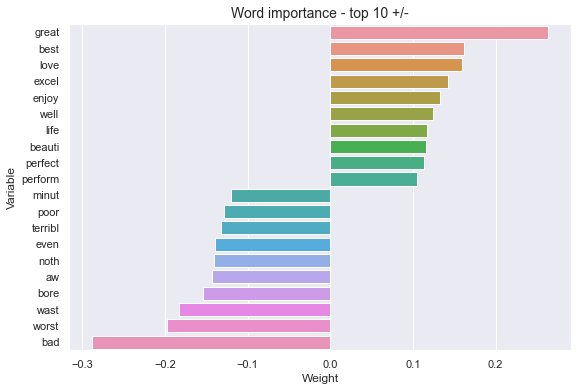

In [119]:
plot_importance(grid_search4.best_estimator_.get_params()['steps'][1][1].coef_[0],
                grid_search4.best_estimator_.get_params()['steps'][0][1].get_feature_names())

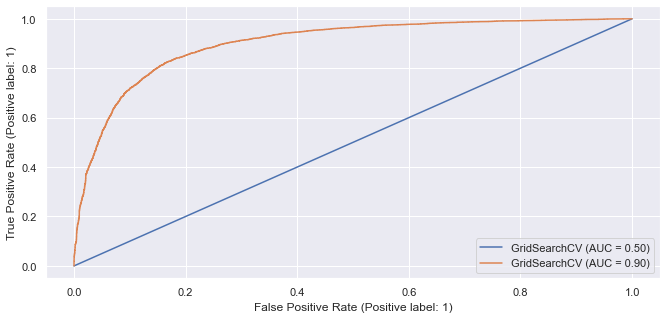

In [120]:
compare_models(grid_search3, grid_search4, data_test_stem, target_test) # blue - tfidf, orange - countvectorizer

As we can see above, first model with stemming doesn't really learn anything, but the second one is very good - AUC same as before with lemmatization. So we will continue with CountVectorizer and rather lemmatization as it performed quite well with both vectorizers.

#### SVM

In [124]:
svm_pipe1 = Pipeline([
    ('vectorizer',CountVectorizer(ngram_range=(1, 3), max_features=1000)),
    ('model', SVC())
])

parameters = [{'model__kernel': ['rbf'], 
               'model__gamma': [1e-3, 1e-4],
               'model__C': [1, 10, 100, 1000]},]


grid_search11 = GridSearchCV(svm_pipe1, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)

In [126]:
grid_search11.fit(data_train_lemma, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ..model__C=1, model__gamma=0.001, model__kernel=rbf; total time= 2.2min
[CV] END ..model__C=1, model__gamma=0.001, model__kernel=rbf; total time= 2.1min
[CV] END ..model__C=1, model__gamma=0.001, model__kernel=rbf; total time= 2.0min
[CV] END .model__C=1, model__gamma=0.0001, model__kernel=rbf; total time= 2.6min
[CV] END .model__C=1, model__gamma=0.0001, model__kernel=rbf; total time= 1.7min
[CV] END .model__C=1, model__gamma=0.0001, model__kernel=rbf; total time= 1.6min
[CV] END .model__C=10, model__gamma=0.001, model__kernel=rbf; total time=  59.2s
[CV] END .model__C=10, model__gamma=0.001, model__kernel=rbf; total time= 1.0min
[CV] END .model__C=10, model__gamma=0.001, model__kernel=rbf; total time= 1.1min
[CV] END model__C=10, model__gamma=0.0001, model__kernel=rbf; total time= 1.4min
[CV] END model__C=10, model__gamma=0.0001, model__kernel=rbf; total time= 1.4min
[CV] END model__C=10, model__gamma=0.0001, model_

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_features=1000,
                                                        ngram_range=(1, 3))),
                                       ('model', SVC())]),
             param_grid=[{'model__C': [1, 10, 100, 1000],
                          'model__gamma': [0.001, 0.0001],
                          'model__kernel': ['rbf']}],
             scoring='f1', verbose=2)

In [127]:
grid_search11.best_params_

{'model__C': 10, 'model__gamma': 0.001, 'model__kernel': 'rbf'}

In [129]:
y_pred = grid_search11.predict(data_test_lemma)

In [130]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      4979
           1       0.84      0.87      0.85      5021

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



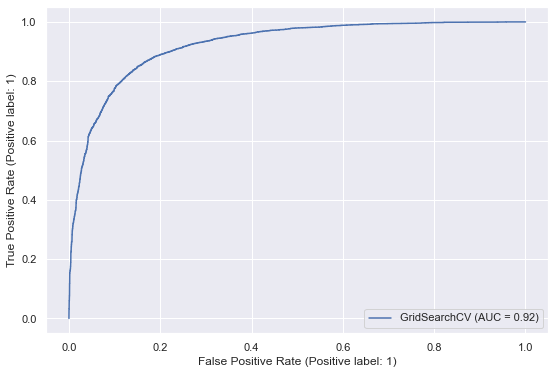

In [131]:
plot_roc_curve(grid_search11,data_test_lemma, target_test)

SVM with CountVectorizer and lemmatization gave us even better result than before - we can see better roc curve and highest AUC so far, as well as the other stats.

#### Naive Bayes

In [139]:
nb_pipe1 = Pipeline([
    ('vectorizer',CountVectorizer(ngram_range=(1,3), max_features=1000) ),
    ('model', MultinomialNB())
])

tuned_parameters = [{'model__alpha': [0.5, 1.0, 5, 10], 
                     'model__fit_prior':[True, False]}]

grid_search111 = GridSearchCV(nb_pipe1, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1', verbose=2)

In [140]:
grid_search111.fit(data_train_lemma, target_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ............model__alpha=0.5, model__fit_prior=True; total time=  30.9s
[CV] END ............model__alpha=0.5, model__fit_prior=True; total time=  26.9s
[CV] END ............model__alpha=0.5, model__fit_prior=True; total time=  23.3s
[CV] END ...........model__alpha=0.5, model__fit_prior=False; total time=  21.1s
[CV] END ...........model__alpha=0.5, model__fit_prior=False; total time=  13.0s
[CV] END ...........model__alpha=0.5, model__fit_prior=False; total time=  26.9s
[CV] END ............model__alpha=1.0, model__fit_prior=True; total time=  25.8s
[CV] END ............model__alpha=1.0, model__fit_prior=True; total time=  22.6s
[CV] END ............model__alpha=1.0, model__fit_prior=True; total time=  19.7s
[CV] END ...........model__alpha=1.0, model__fit_prior=False; total time=  25.1s
[CV] END ...........model__alpha=1.0, model__fit_prior=False; total time=  29.0s
[CV] END ...........model__alpha=1.0, model__fit_

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_features=1000,
                                                        ngram_range=(1, 3))),
                                       ('model', MultinomialNB())]),
             param_grid=[{'model__alpha': [0.5, 1.0, 5, 10],
                          'model__fit_prior': [True, False]}],
             scoring='f1', verbose=2)

In [142]:
grid_search111.best_params_

{'model__alpha': 1.0, 'model__fit_prior': False}

In [143]:
y_pred = grid_search111.predict(data_test_lemma)

In [144]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      4979
           1       0.82      0.85      0.83      5021

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



Naive Bayes model performs quite well, similar to SGD.

In [ ]:
plot_roc_curve(grid_search111, data_test_lemma, target_test)

In [ ]:
### Extra work - some other models 

In [122]:
rf_pipe = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1,3), max_features=1000) ),
    ('model', RandomForestClassifier(criterion = 'entropy'))
])

tuned_parameters = [{'model__n_estimators': [50, 100, 300]}]

grid_search_extra = GridSearchCV(rf_pipe, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1')

In [123]:
grid_search_extra.fit(data_train_lemma2, target_train2)

KeyboardInterrupt: 